# Unsupervised anomaly detection
After our initial EDA, we have decided to pursue some unsupervised anomaly detection with a feature for the number of usernames with a failed login attempt in a given minute.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import sqlite3

with sqlite3.connect('logs/logs.db') as conn:
    logs_2018 = pd.read_sql(
        'SELECT * FROM logs WHERE datetime BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['datetime'], index_col='datetime'
    )
logs_2018.head()

,source_ip,username,success,failure_reason
datetime,,,,
2018-01-01 00:00:54.641251,41.253.247.255,admin,1,None
2018-01-01 01:17:56.801849,230.71.97.153,zbrown,1,None
2018-01-01 02:48:52.437529,204.205.71.171,ckim,1,None
2018-01-01 03:32:15.644139,126.228.43.201,qjones,1,None
2018-01-01 03:50:42.710112,204.205.71.171,ckim,1,None


## Prepping our data

In [3]:
def get_X(log, day):
    """
    Get data we can use for the X
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
    
    Returns: 
        A pandas DataFrame
    """
    return pd.get_dummies(log[day].assign(
        failures=lambda x: 1 - x.success
    ).query('failures > 0').resample('1min').agg(
        {'username':'nunique', 'failures': 'sum'}
    ).dropna().rename(
        columns={'username':'usernames_with_failures'}
    ).assign(
        day_of_week=lambda x: x.index.dayofweek, 
        hour=lambda x: x.index.hour
    ).drop(columns=['failures']), columns=['day_of_week', 'hour'])

In [4]:
X = get_X(logs_2018, '2018-01')
X.columns

Index(['usernames_with_failures', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

## Isolation Forest

In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

iso_forest_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('iforest', IsolationForest(
        random_state=0, contamination=0.05, behaviour='new'
    ))
]).fit(X)

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [6]:
isolation_forest_preds = iso_forest_pipeline.predict(X)
pd.Series(np.where(
    isolation_forest_preds == -1, 'outlier', 'inlier'
)).value_counts()

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


inlier     42395
outlier     1951
dtype: int64

### Local Outlier Factor

In [7]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lof_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lof', LocalOutlierFactor())
]).fit(X)

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [8]:
lof_preds = lof_pipeline.named_steps['lof'].negative_outlier_factor_ 
lof_preds

array([-1.55399392e+10, -1.00000000e+00, -1.00000000e+00, ...,
       -1.00000000e+00, -1.00000000e+00, -1.33980708e+10])

In [9]:
pd.Series(np.where(
    lof_preds < lof_pipeline.named_steps['lof'].offset_, 'outlier', 'inlier'
)).value_counts()

inlier     43505
outlier      841
dtype: int64

### Check agreement between unsupervised methods

In [10]:
from sklearn.metrics import cohen_kappa_score

is_lof_outlier = np.where(
    lof_preds < lof_pipeline.named_steps['lof'].offset_, 
    'outlier', 'inlier'
)
is_iso_outlier = np.where(
    isolation_forest_preds == -1, 'outlier', 'inlier'
)

cohen_kappa_score(is_lof_outlier, is_iso_outlier)

0.591611553569184

### Evaluating the models
We have been given the labeled data. Now we can truly compare these models.

In [11]:
with sqlite3.connect('logs/logs.db') as conn:
    hackers_2018 = pd.read_sql(
        """
        SELECT * 
        FROM attacks 
        WHERE start BETWEEN "2018-01-01" AND "2019-01-01";
        """, conn, parse_dates=['start', 'end']
    ).assign(
        duration=lambda x: x.end - x.start,
        start_floor=lambda x: x.start.dt.floor('min'),
        end_ceil=lambda x: x.end.dt.ceil('min')
    )
hackers_2018.shape

(90, 6)

In [12]:
hackers_2018.head()

,start,end,source_ip,duration,start_floor,end_ceil
0,2018-01-06 18:16:31.457615,2018-01-06 18:20:36.457615,36.157.72.36,00:04:05,2018-01-06 18:16:00,2018-01-06 18:21:00
1,2018-01-07 02:56:36.250248,2018-01-07 02:57:44.250248,223.110.52.156,00:01:08,2018-01-07 02:56:00,2018-01-07 02:58:00
2,2018-01-18 18:17:38.528300,2018-01-18 18:21:29.528300,197.93.26.109,00:03:51,2018-01-18 18:17:00,2018-01-18 18:22:00
3,2018-01-26 10:19:44.261965,2018-01-26 10:20:52.261965,128.95.219.5,00:01:08,2018-01-26 10:19:00,2018-01-26 10:21:00
4,2018-01-28 01:05:32.451123,2018-01-28 01:09:33.451123,187.62.145.110,00:04:01,2018-01-28 01:05:00,2018-01-28 01:10:00


In [13]:
def get_y(datetimes, hackers, resolution='1min'):
    """
    Get data we can use for the y (whether or not a hacker attempted a log in during that time).
    
    Parameters:
        - datetimes: The datetimes to check for hackers
        - hackers: The dataframe indicating when the attacks started and stopped
        - resolution: The granularity of the datetime. Default is 1 minute.
        
    Returns:
        A pandas Series of booleans.
    """
    date_ranges = hackers.apply(
        lambda x: pd.date_range(x.start_floor, x.end_ceil, freq=resolution), 
        axis=1
    )
    dates = pd.Series()
    for date_range in date_ranges:
        dates = pd.concat([dates, date_range.to_series()])
    return datetimes.isin(dates)

In [14]:
is_hacker = get_y(X.reset_index().datetime, hackers_2018)

In [15]:
# create partials for less typing
from functools import partial
from sklearn.metrics import classification_report
from utils import confusion_matrix_visual

report = partial(classification_report, is_hacker)
conf_matrix = partial(
    confusion_matrix_visual, is_hacker, class_labels=[False, True]
)

#### Isolation forest

In [16]:
iso_forest_predicts_hacker = isolation_forest_preds == - 1

In [17]:
print(report(iso_forest_predicts_hacker))

              precision    recall  f1-score   support

       False       1.00      0.96      0.98     44322
        True       0.01      0.79      0.02        24

   micro avg       0.96      0.96      0.96     44346
   macro avg       0.50      0.87      0.50     44346
weighted avg       1.00      0.96      0.98     44346



#### Local Outlier Factor

In [18]:
lof_predicts_hacker = lof_preds < lof_pipeline.named_steps['lof'].offset_

In [19]:
print(report(lof_predicts_hacker))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99     44322
        True       0.02      0.79      0.04        24

   micro avg       0.98      0.98      0.98     44346
   macro avg       0.51      0.89      0.52     44346
weighted avg       1.00      0.98      0.99     44346



#### Comparing confusion matrices

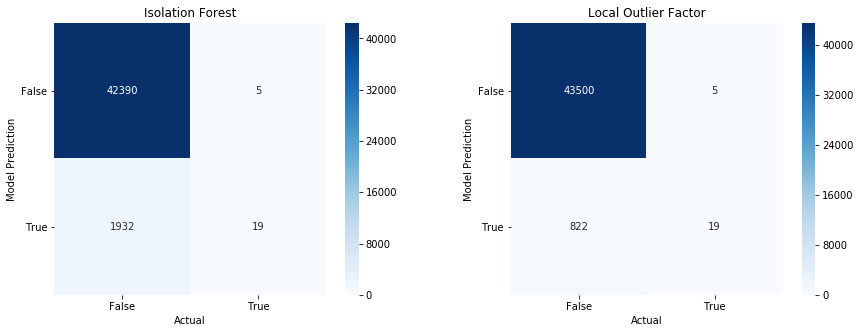

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
conf_matrix(iso_forest_predicts_hacker, ax=axes[0], title='Isolation Forest')
conf_matrix(lof_predicts_hacker, ax=axes[1], title='Local Outlier Factor')